In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_csv("PVEVDATA.csv")
df.columns = [col.strip().replace(" ", "_") for col in df.columns]
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Solar_Power_kW         1000 non-null   float64
 1   Solar_Irradiance_Wm2   1000 non-null   float64
 2   Battery_SOC_%          1000 non-null   float64
 3   Charging_Power_kW      1000 non-null   float64
 4   Charging_Duration_Min  1000 non-null   int64  
 5   Initial_Battery_SOC_%  1000 non-null   float64
 6   Final_Battery_SOC_%    1000 non-null   float64
 7   Grid_Energy_Supply_kW  1000 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 62.6 KB
None
   Solar_Power_kW  Solar_Irradiance_Wm2  Battery_SOC_%  Charging_Power_kW  \
0        2.322521            846.023927      68.875714           7.974305   
1       36.480309            652.070250      19.492633          10.109182   
2       47.696429            798.937167      13.120324          11.336879   
3       36.

In [8]:
df["Solar_Consumption_By_Battery_kWh"] = df["Solar_Power_kW"] * df["Charging_Duration_Min"] / 60
df = df.dropna()
df = df[df["Solar_Consumption_By_Battery_kWh"] > 0]

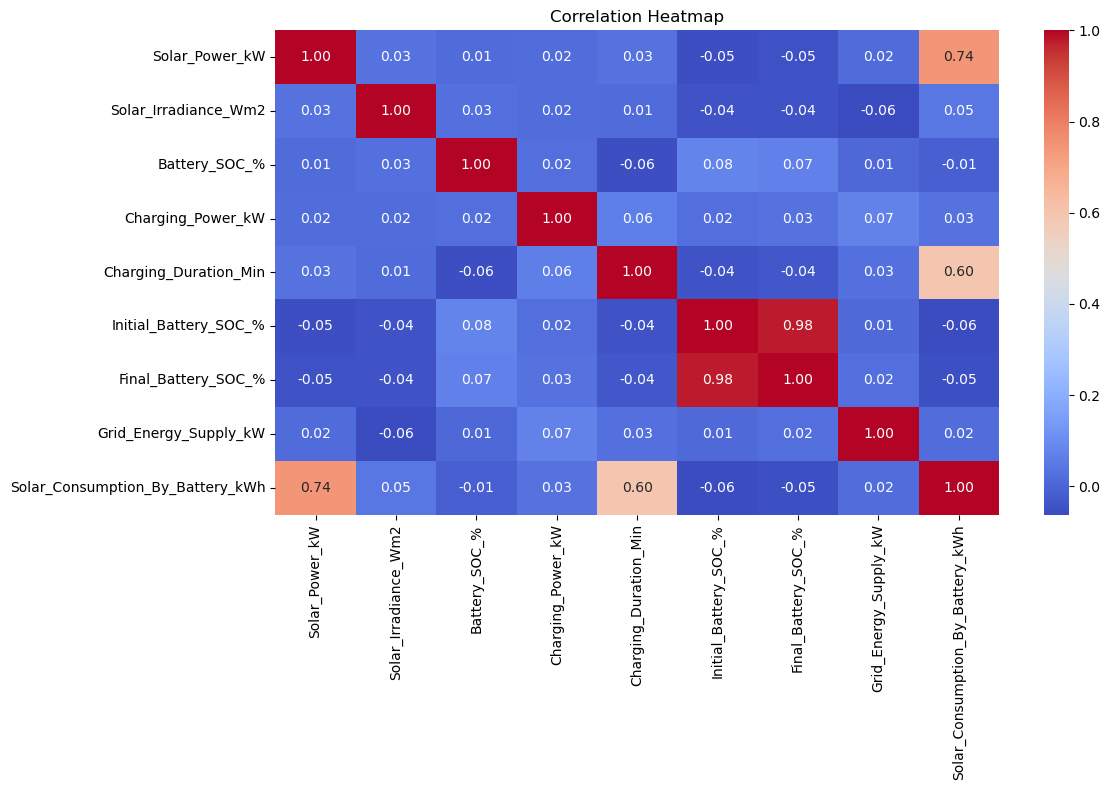

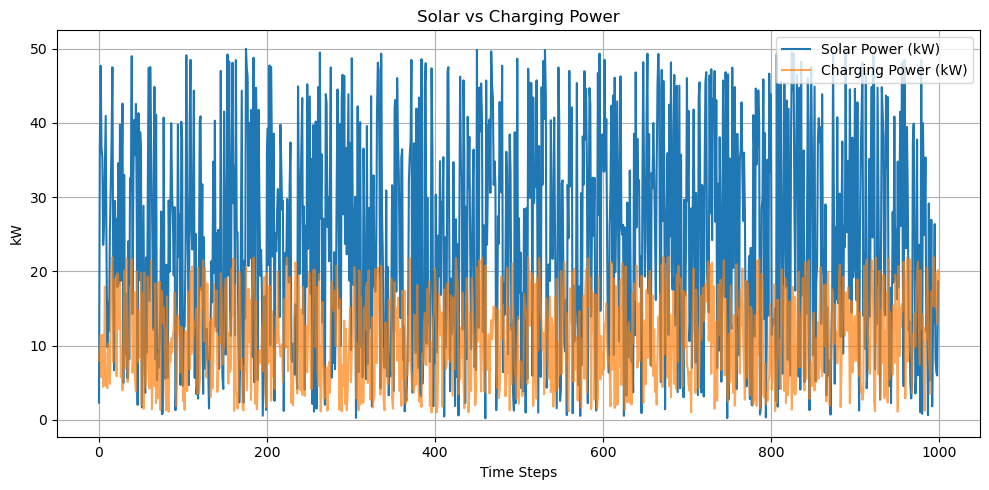

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Solar Power vs Charging Power over time
plt.figure(figsize=(10, 5))
plt.plot(df['Solar_Power_kW'], label='Solar Power (kW)')
plt.plot(df['Charging_Power_kW'], label='Charging Power (kW)', alpha=0.7)
plt.legend()
plt.title("Solar vs Charging Power")
plt.xlabel("Time Steps")
plt.ylabel("kW")
plt.grid(True)
plt.tight_layout()
plt.show()

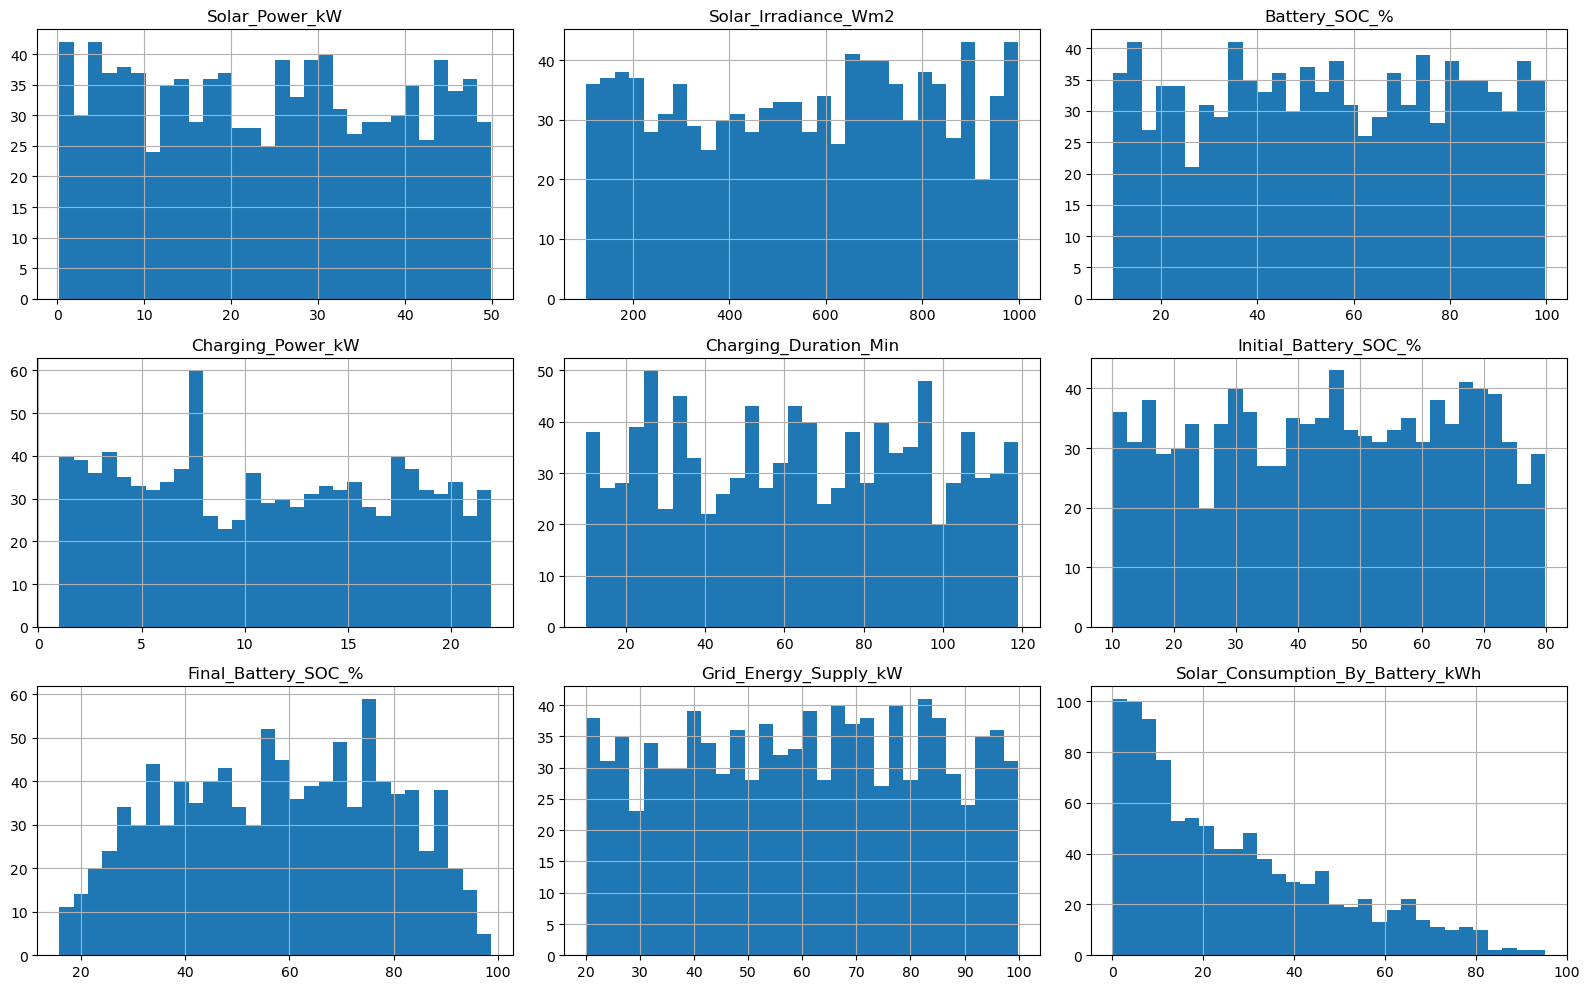

In [12]:
df.hist(bins=30, figsize=(16,10))
plt.tight_layout()
plt.show()

In [20]:
features = [
    "Solar_Power_kW", "Solar_Irradiance_Wm2", "Battery_SOC_%",
    "Charging_Power_kW", "Charging_Duration_Min",
    "Initial_Battery_SOC_%", "Final_Battery_SOC_%"]


X = df[features].values
y = df["Solar_Consumption_By_Battery_kWh"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


X_val_tensor = torch.tensor(X_val, dtype=torch.float32)


In [24]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

model = MLPRegressor(X_train.shape[1])


In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train_losses = []
val_losses = []


In [28]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch [10/100] - Train Loss: 1172.7429, Val Loss: 1045.3188
Epoch [20/100] - Train Loss: 1129.3766, Val Loss: 1003.1489
Epoch [30/100] - Train Loss: 1070.3459, Val Loss: 945.7706
Epoch [40/100] - Train Loss: 990.6584, Val Loss: 869.0068
Epoch [50/100] - Train Loss: 887.7731, Val Loss: 771.2675
Epoch [60/100] - Train Loss: 763.2766, Val Loss: 655.1866
Epoch [70/100] - Train Loss: 624.9529, Val Loss: 529.5938
Epoch [80/100] - Train Loss: 487.7190, Val Loss: 410.0387
Epoch [90/100] - Train Loss: 370.7056, Val Loss: 314.1656
Epoch [100/100] - Train Loss: 287.0724, Val Loss: 251.2786


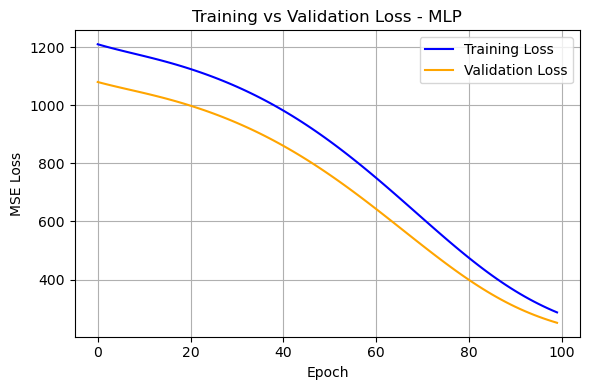

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss - MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mlp_loss_plot.png", dpi=300)
plt.show()


In [13]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

E:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1120.3666 - root_mean_squared_error: 33.4459 - val_loss: 968.5708 - val_root_mean_squared_error: 31.1219
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1071.8417 - root_mean_squared_error: 32.7102 - val_loss: 696.5759 - val_root_mean_squared_error: 26.3927
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 670.1760 - root_mean_squared_error: 25.8510 - val_loss: 343.1671 - val_root_mean_squared_error: 18.5248
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 323.5952 - root_mean_squared_error: 17.9722 - val_loss: 210.8861 - val_root_mean_squared_error: 14.5219
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 185.1621 - root_mean_squared_error: 13.5920 - val_loss: 109.7240 - val_root_mean_squared_error: 10.4749
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 104.7069 - root_mean_squared_error: 10.2273 - val_loss: 61.3153 - val_root_mean_squared_error: 7.8304
Epoch 7/200
20/20 ━━━

In [17]:
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² Score: 0.9970
MSE: 1.28


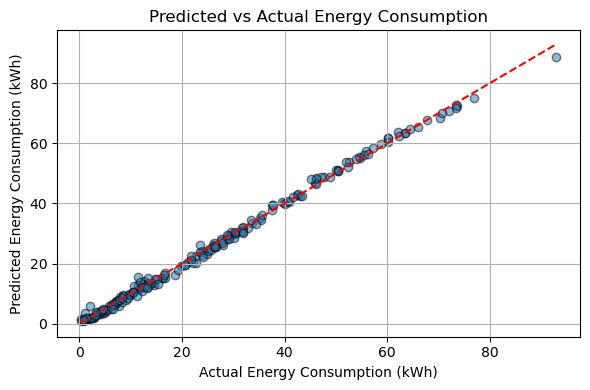

<Figure size 640x480 with 0 Axes>

In [29]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Energy Consumption (kWh)")
plt.ylabel("Predicted Energy Consumption (kWh)")
plt.title("Predicted vs Actual Energy Consumption")
plt.grid(True)
plt.tight_layout()
plt.show()